In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evallm
from automata.fa.dfa import DFA
import tqdm.auto as tqdm

In [3]:
import itertools

In [4]:
from evallm.experiments.transducer_experiment import (
    current_transducer_experiments,
    compute_relative_to_null,
    compute_relative_to_ngram,
    plot_relative_results,
    print_example,
    bottom_quartile_outcome,
    plot_all_absolute_results,
)

In [5]:
from evallm.prompting.transducer_prompt import (
    ChainOfThoughtPromptRealExampleNoExplanation,
)

In [19]:
# cot = ChainOfThoughtPromptRealExampleNoExplanation(
#     30, dict(type="sample_reachable_dfa", n_states=3, n_symbols=3), 1
# )

In [20]:
# from evallm.sample_dfa.sample_dfa import sample_dfa

# dfa = sample_dfa(
#     dict(type="sample_reachable_dfa", n_states=3, n_symbols=3), np.random.RandomState(0)
# )
# dfa

In [21]:
# print(cot.prompt_and_answer(dfa, np.random.RandomState(0), is_chat=True)[1]["user"])

In [10]:
results = {
    "llama3-8B": current_transducer_experiments(),
    # "gpt-3.5": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
    #     "gpt-3.5-turbo-0125"
    # ),
    "gpt-4o-mini": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
    ),
    "gpt-4o-mini + real eg": evallm.experiments.transducer_experiment.chatgpt_transducer_experiments(
        "gpt-4o-mini-2024-07-18",
        lambda num_sequence_symbols, sample_dfa_spec: ChainOfThoughtPromptRealExampleNoExplanation(
            num_sequence_symbols, sample_dfa_spec, 1
        ),
    ),
}

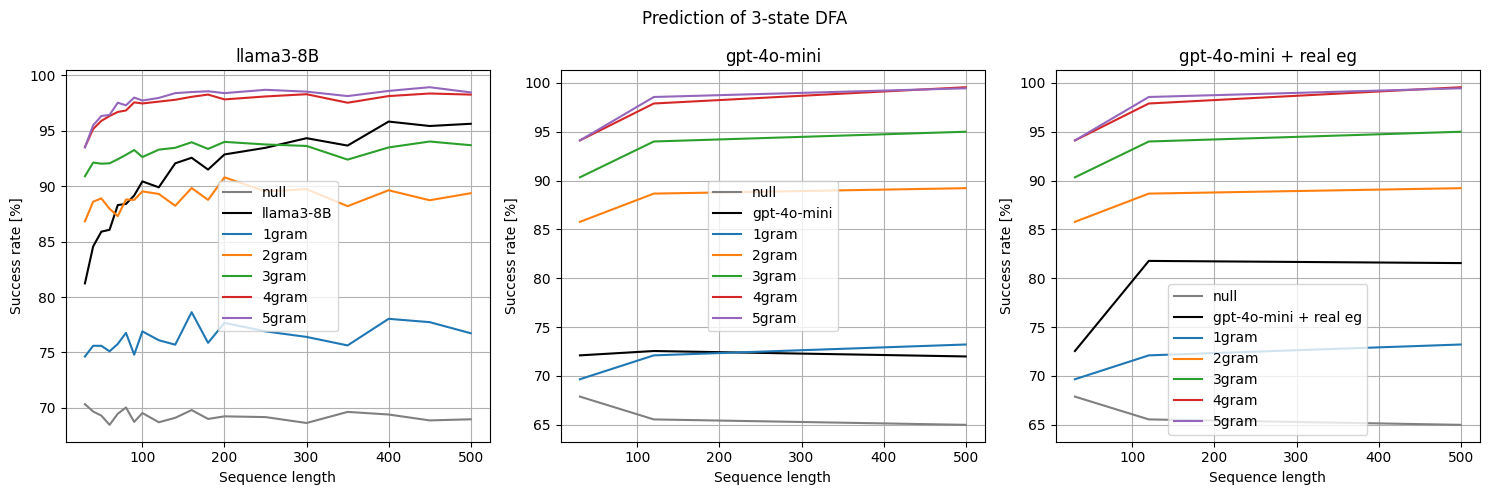

In [11]:
plot_all_absolute_results(results, 3)

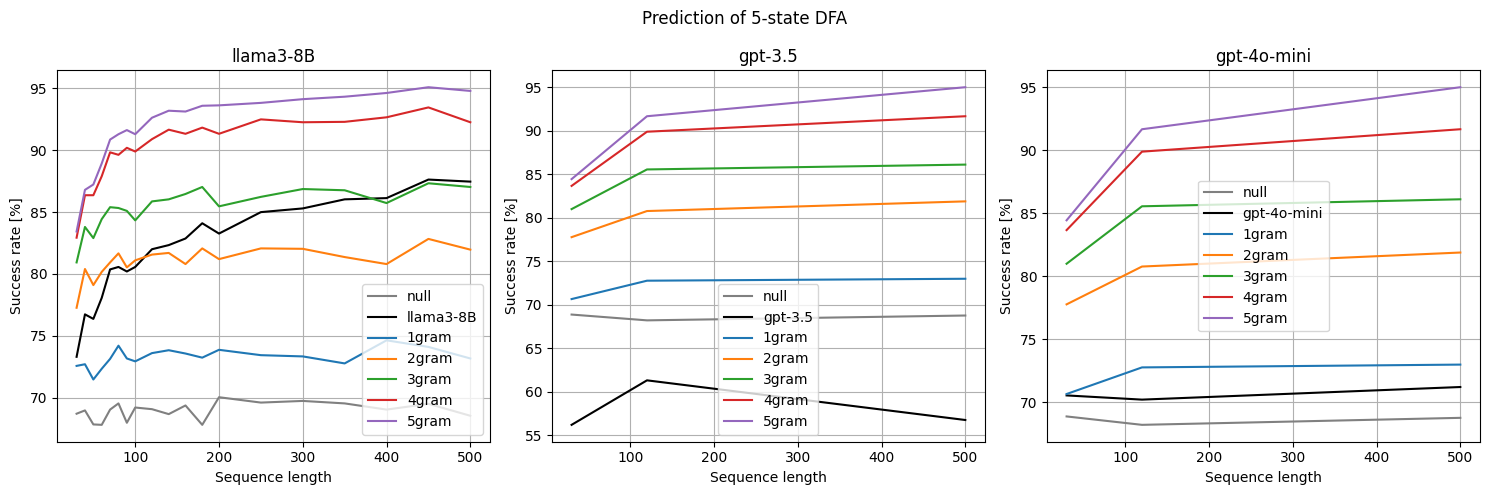

In [7]:
plot_all_absolute_results(results, 5)

In [8]:
prompter = evallm.prompting.transducer_prompt.ChainOfThoughtPrompt(30)

In [9]:
print_example(
    "gpt-3.5-turbo-0125", prompter, bottom_quartile_outcome(results["gpt-3.5"][3][30])
)

********* EXAMPLE 0: WRONG ***********
######### SYSTEM ############
You are a question answering system. For each question, think step by step and place your answer between tags like <answer>0</answer> or <answer>1</answer>. MAKE SURE TO PUT YOUR ANSWER IN ANSWER TAGS or you will get NO CREDIT.
QUESTION:
What is 20*2?
ANSWER:
To solve this problem, we need to multiply 20 by 0. We can accomplish this via noticing that anything multiplied by 0 is 0. <answer>0</answer>

######### USER ############
QUESTION:
A DFA was used to create these outputs given a random sequence of inputs. Your job is to fill in the last output:
in: a, out: 0
in: c, out: 1
in: b, out: 0
in: a, out: 1
in: b, out: 0
in: a, out: 1
in: c, out: 1
in: a, out: 0
in: a, out: 1
in: a, out: 0
in: b, out: 1
in: b, out: 0
in: c, out: 1
in: b, out: 0
in: a, out: 1
in: a, out: 0
in: a, out: 1
in: a, out: 0
in: b, out: 1
in: b, out: 0
in: c, out: 1
in: b, out: 0
in: b, out: 1
in: c, out: 1
in: c, out: 1
in: b, out: 0
in: c, out:

In [10]:
print_example(
    "gpt-4o-mini-2024-07-18",
    prompter,
    bottom_quartile_outcome(results["gpt-4o-mini"][3][30]),
)

********* EXAMPLE 0: WRONG ***********
######### SYSTEM ############
You are a question answering system. For each question, think step by step and place your answer between tags like <answer>0</answer> or <answer>1</answer>. MAKE SURE TO PUT YOUR ANSWER IN ANSWER TAGS or you will get NO CREDIT.
QUESTION:
What is 20*2?
ANSWER:
To solve this problem, we need to multiply 20 by 0. We can accomplish this via noticing that anything multiplied by 0 is 0. <answer>0</answer>

######### USER ############
QUESTION:
A DFA was used to create these outputs given a random sequence of inputs. Your job is to fill in the last output:
in: b, out: 1
in: c, out: 0
in: b, out: 0
in: b, out: 0
in: a, out: 1
in: a, out: 0
in: b, out: 0
in: a, out: 1
in: b, out: 1
in: c, out: 0
in: c, out: 0
in: b, out: 0
in: b, out: 0
in: a, out: 1
in: b, out: 1
in: b, out: 1
in: a, out: 0
in: c, out: 0
in: a, out: 1
in: c, out: 0
in: c, out: 0
in: b, out: 0
in: c, out: 0
in: c, out: 0
in: a, out: 1
in: b, out: 1
in: a, out: